# (28) Fit — Pois + Lin — 1

**Motivation**: First fit after code cleanup. Reproduces? Device = ```cuda:1``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
from figures.fighelper import *
from torch.nn import functional as F
from vae.vae import PoissonVAE, ConfigPoisVAE
from vae.train_vae import TrainerVAE, ConfigTrainVAE

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

## Build model + trainer

In [2]:
vae = PoissonVAE(ConfigPoisVAE())
tr = TrainerVAE(model=vae, cfg=ConfigTrainVAE(lr=0.01), device='cuda:1')

In [3]:
vae.print()
print(f"{vae.cfg.name()}\n{tr.cfg.name()}")

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|  PoissonVAE |  262.7 K   |
|     ---     |    ---     |
|    fc_enc   |  131.1 K   |
|    fc_dec   |  131.1 K   |
+-------------+------------+

poisson_uniform_c(-3.00)_DOVES_z-512_k-32_lin+lin
ep3600-b1000-lr(0.01)_beta(1:0x0.3)_temp(1.0-0.1:0.8)_gr(500)

In [4]:
vae.log_rates.detach().exp().min(), vae.log_rates.detach().exp().max()

(tensor(0.0025, device='cuda:1'), tensor(0.0494, device='cuda:1'))

## Train

In [5]:
# comment = f"..._{tr.cfg.name()}"
tr.train(comment=tr.cfg.name())

epoch # 3600, avg loss: 165.484663: 100%|█████████████████████████████████████████████████████| 3600/3600 [28:33<00:00,  2.10it/s]


## Eval

In [6]:
data, loss, rates = tr.validate(freeze=False, use_ema=False)
loss = {k: v.mean() for k, v in loss.items()}
loss['tot'] = loss['mse'] + loss['kl']
print(loss)

{'mse': 132.11531, 'kl': 31.051619, 'kl_diag': 0.060021535, 'tot': 163.16693}

In [7]:
data, loss, rates = tr.validate(freeze=True, use_ema=False)
data_ema, loss_ema, rates_ema = tr.validate(freeze=True, use_ema=True)

In [8]:
loss_summary = {
    k: {
        'vae': np.round(v.mean(), 2),
        'ema': np.round(loss_ema[k].mean(), 2),
    } for k, v in loss.items()
}
print(f"{vae.cfg.name()}\n{tr.cfg.name()}\n\n{loss_summary}\n")

poisson_uniform_c(-3.00)_DOVES_z-512_k-32_lin+lin
ep3600-b1000-lr(0.01)_beta(1:0x0.3)_temp(1.0-0.1:0.8)_gr(500)

{'mse': {'vae': 136.05, 'ema': 832.46}, 'kl': {'vae': 31.05, 'ema': 31.05}, 'kl_diag': {'vae': 0.06, 'ema': 0.06}}

In [9]:
tr.model.temp, tr.cfg.kl_beta

(0.1, 1.0)

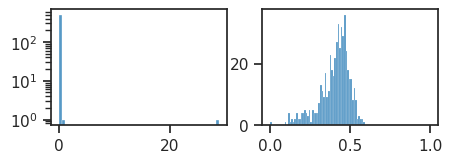

In [12]:
r8s = rates['r*dr'].mean(0)

fig, axes = create_figure(1, 2, (5, 1.5))
sns.histplot(r8s, bins=50, ax=axes[0])
sns.histplot(r8s, bins=np.linspace(0, 1, 101), ax=axes[1])
for ax in axes.flat:
    ax.set_ylabel('')
axes[0].set_yscale('log')
plt.show()

In [13]:
w_dec = tr.model.fc_dec.weight.T.reshape(tr.model.shape)
w_dec = to_np(w_dec[np.argsort(r8s)])
grid_dec = make_grid(w_dec, (16, 32))

w_dec.shape, grid_dec.shape

((512, 1, 16, 16), (271, 543))

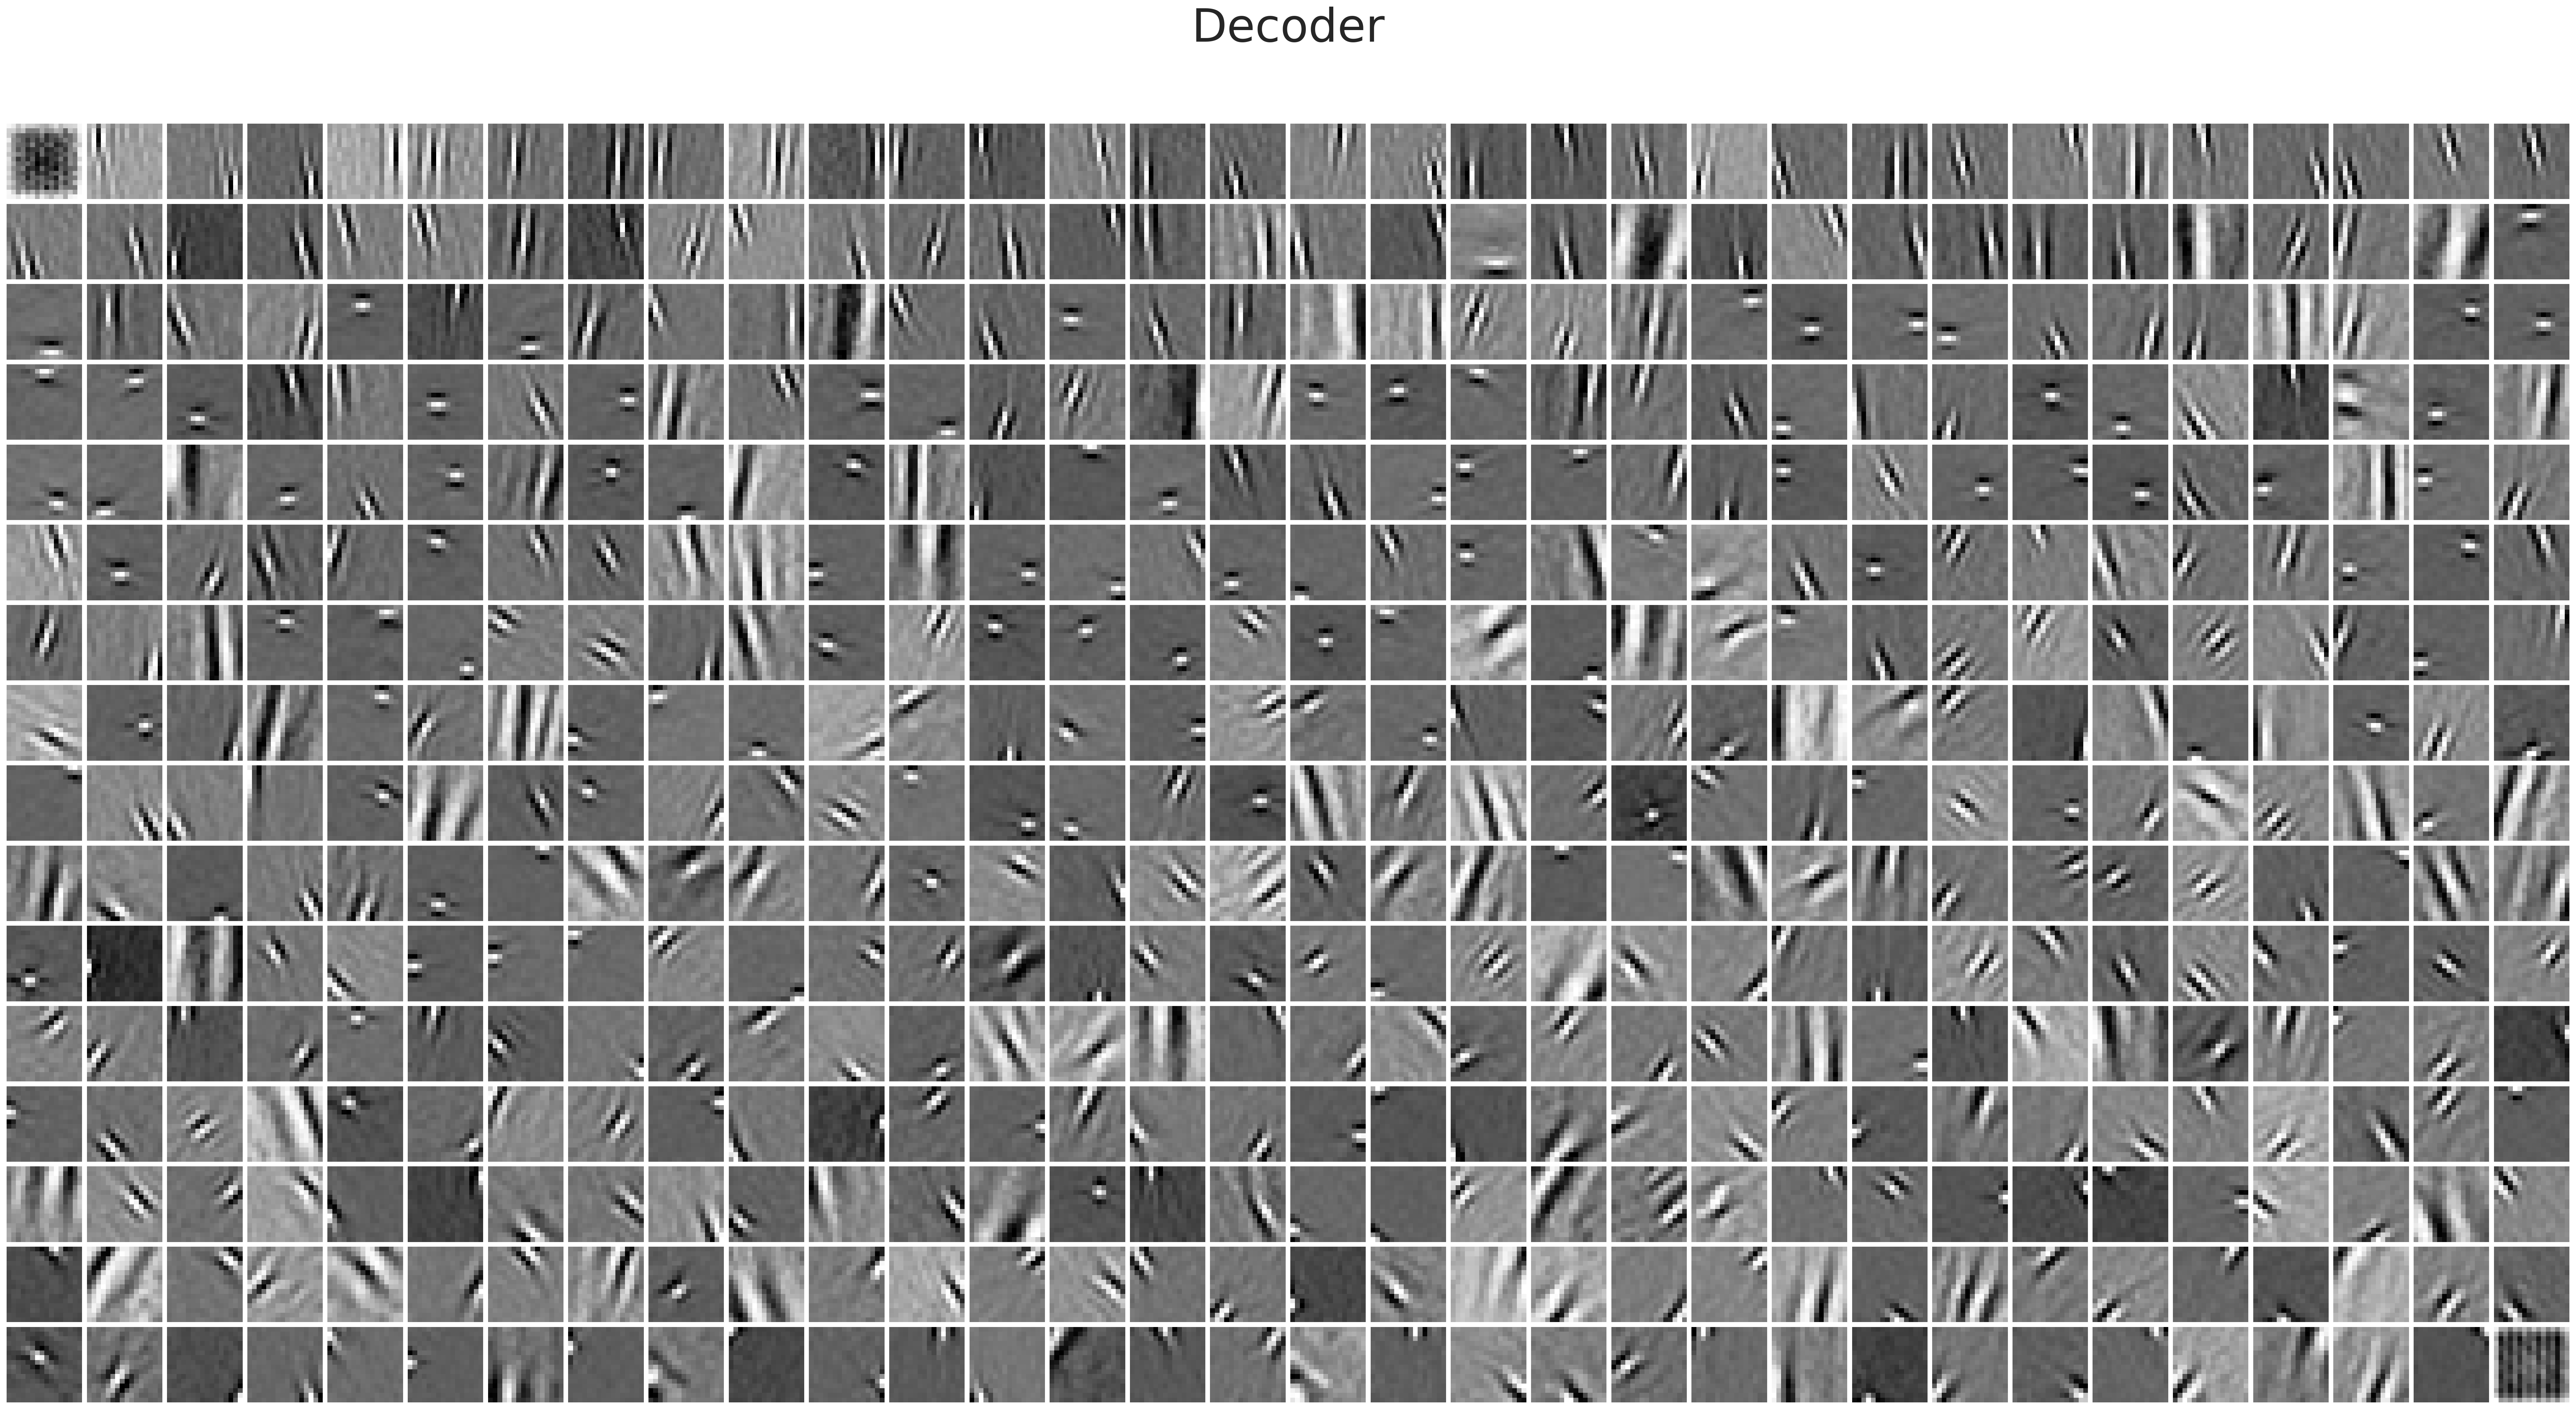

In [14]:
fig, ax = create_figure(1, 1, (50, 26), dpi=200)
ax.imshow(grid_dec, cmap='Greys_r')
ax.set_title('Decoder', fontsize=50, y=1.06)
remove_ticks(ax)
plt.show()

In [15]:
w_enc = tr.model.fc_enc.weight.reshape(tr.model.shape)
w_enc = to_np(w_enc[np.argsort(r8s)])
grid_enc = make_grid(w_enc, (16, 32))

w_enc.shape, grid_enc.shape

((512, 1, 16, 16), (271, 543))

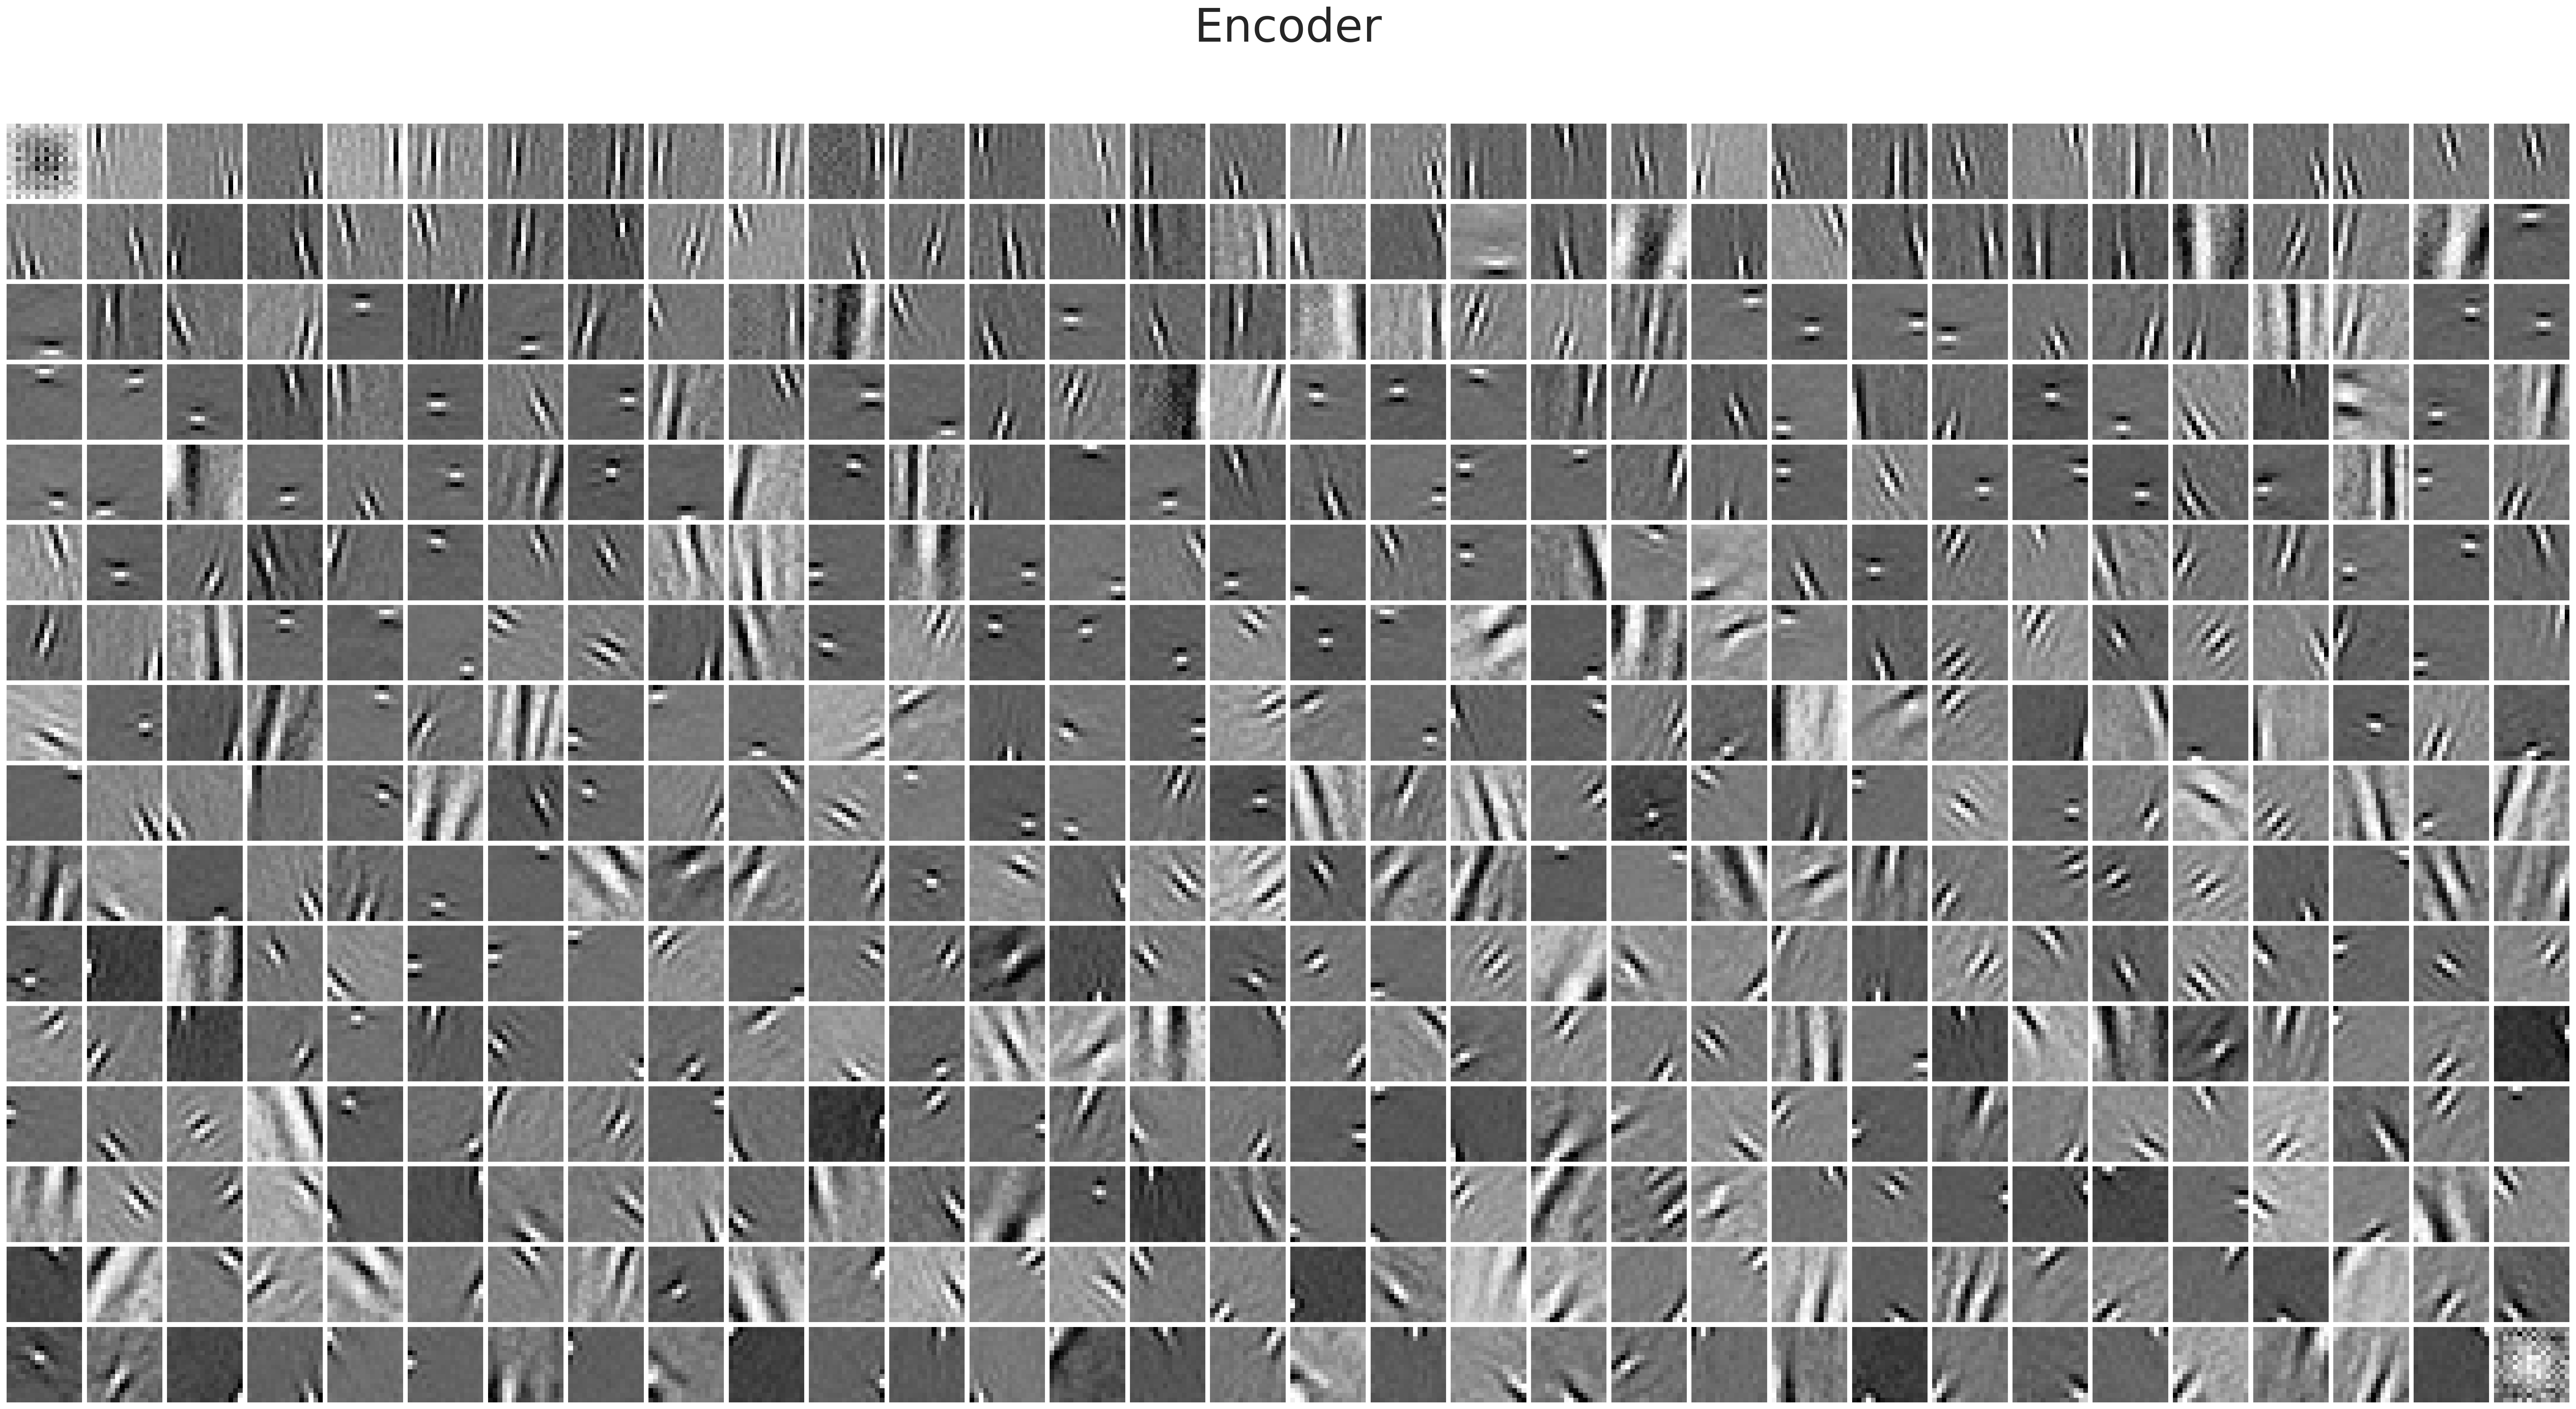

In [16]:
fig, ax = create_figure(1, 1, (50, 26), dpi=200)
ax.imshow(grid_enc, cmap='Greys_r')
ax.set_title('Encoder', fontsize=50, y=1.06)
remove_ticks(ax)
plt.show()

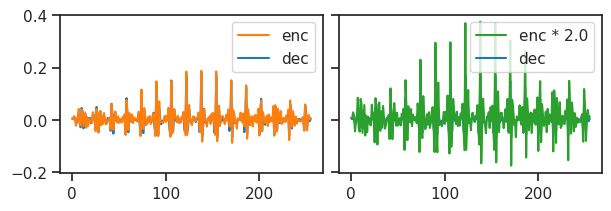

In [17]:
fig, axes = create_figure(1, 2, (6, 2), sharey='row', layout='constrained')

i = 7

axes[0].plot(w_enc[i].ravel(), label='enc', color='C1', zorder=1)
axes[1].plot(w_enc[i].ravel() * 2.0, label='enc * 2.0', color='C2', zorder=1)

for ax in axes.flat:
    ax.plot(w_dec[i].ravel(), label='dec', color='C0', zorder=0)
    ax.legend()

plt.show()

In [18]:
with torch.inference_mode():
    w_dec = tr.model.fc_dec.weight.detach().data
    w_enc = tr.model.fc_enc.weight.detach().data

    cos_sim = F.cosine_similarity(w_dec.T, w_enc)
    slope = torch.einsum('ic, ci -> c', w_dec, w_enc)
    slope /= torch.norm(w_enc, dim=1).pow(2)

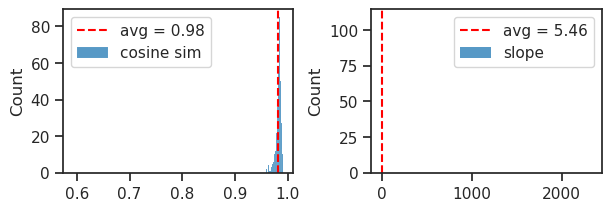

In [19]:
fig, axes = create_figure(1, 2, (6, 2), layout='constrained')

sns.histplot(to_np(cos_sim), label='cosine sim', ax=axes[0])
sns.histplot(to_np(slope), label='slope', ax=axes[1])

_avg = cos_sim.mean().item()
axes[0].axvline(_avg, color='r', ls='--', label=f'avg = {_avg:0.2f}')
_avg = slope.mean().item()
axes[1].axvline(_avg, color='r', ls='--', label=f'avg = {_avg:0.2f}')

for ax in axes.flat:
    ax.legend()
plt.show()

In [20]:
tot = np.prod(data['z'].shape)
portions = collections.Counter(data['z'].ravel().astype(int))
portions = {
    k: v / tot for k, v in
    portions.most_common()
}
portions = {
    k: np.round(v * 100, 1) for
    k, v in portions.items()
    if v > 0.001
}

In [21]:
portions

{0: 68.7, 1: 24.1, 2: 5.5, 3: 1.1, 4: 0.3, 9: 0.2}

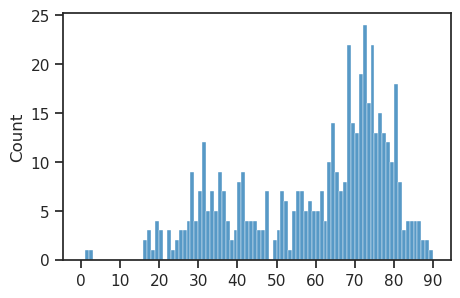

In [23]:
ax = sns.histplot(loss['kl_diag'] * 1000, bins=np.linspace(0, 90, 91))
ax.locator_params(axis='x', nbins=15)

In [30]:
dead = loss['kl_diag'] < 0.01

r8s = rates['r*dr'].mean(0)
r8s = np.delete(r8s, dead)
len(r8s)

510

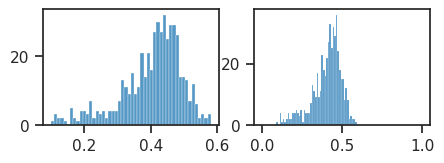

In [31]:
fig, axes = create_figure(1, 2, (5, 1.5))
sns.histplot(r8s, bins=50, ax=axes[0])
sns.histplot(r8s, bins=np.linspace(0, 1, 101), ax=axes[1])
for ax in axes.flat:
    ax.set_ylabel('')
plt.show()

In [32]:
w_dec = tr.model.fc_dec.weight.T.reshape(tr.model.shape)
w_dec = to_np(w_dec)
w_dec[dead] = np.nan

r8s = rates['r*dr'].mean(0)
w_dec = w_dec[np.argsort(r8s)]

grid_dec = make_grid(w_dec, (16, 32))

w_dec.shape, grid_dec.shape

((512, 1, 16, 16), (271, 543))

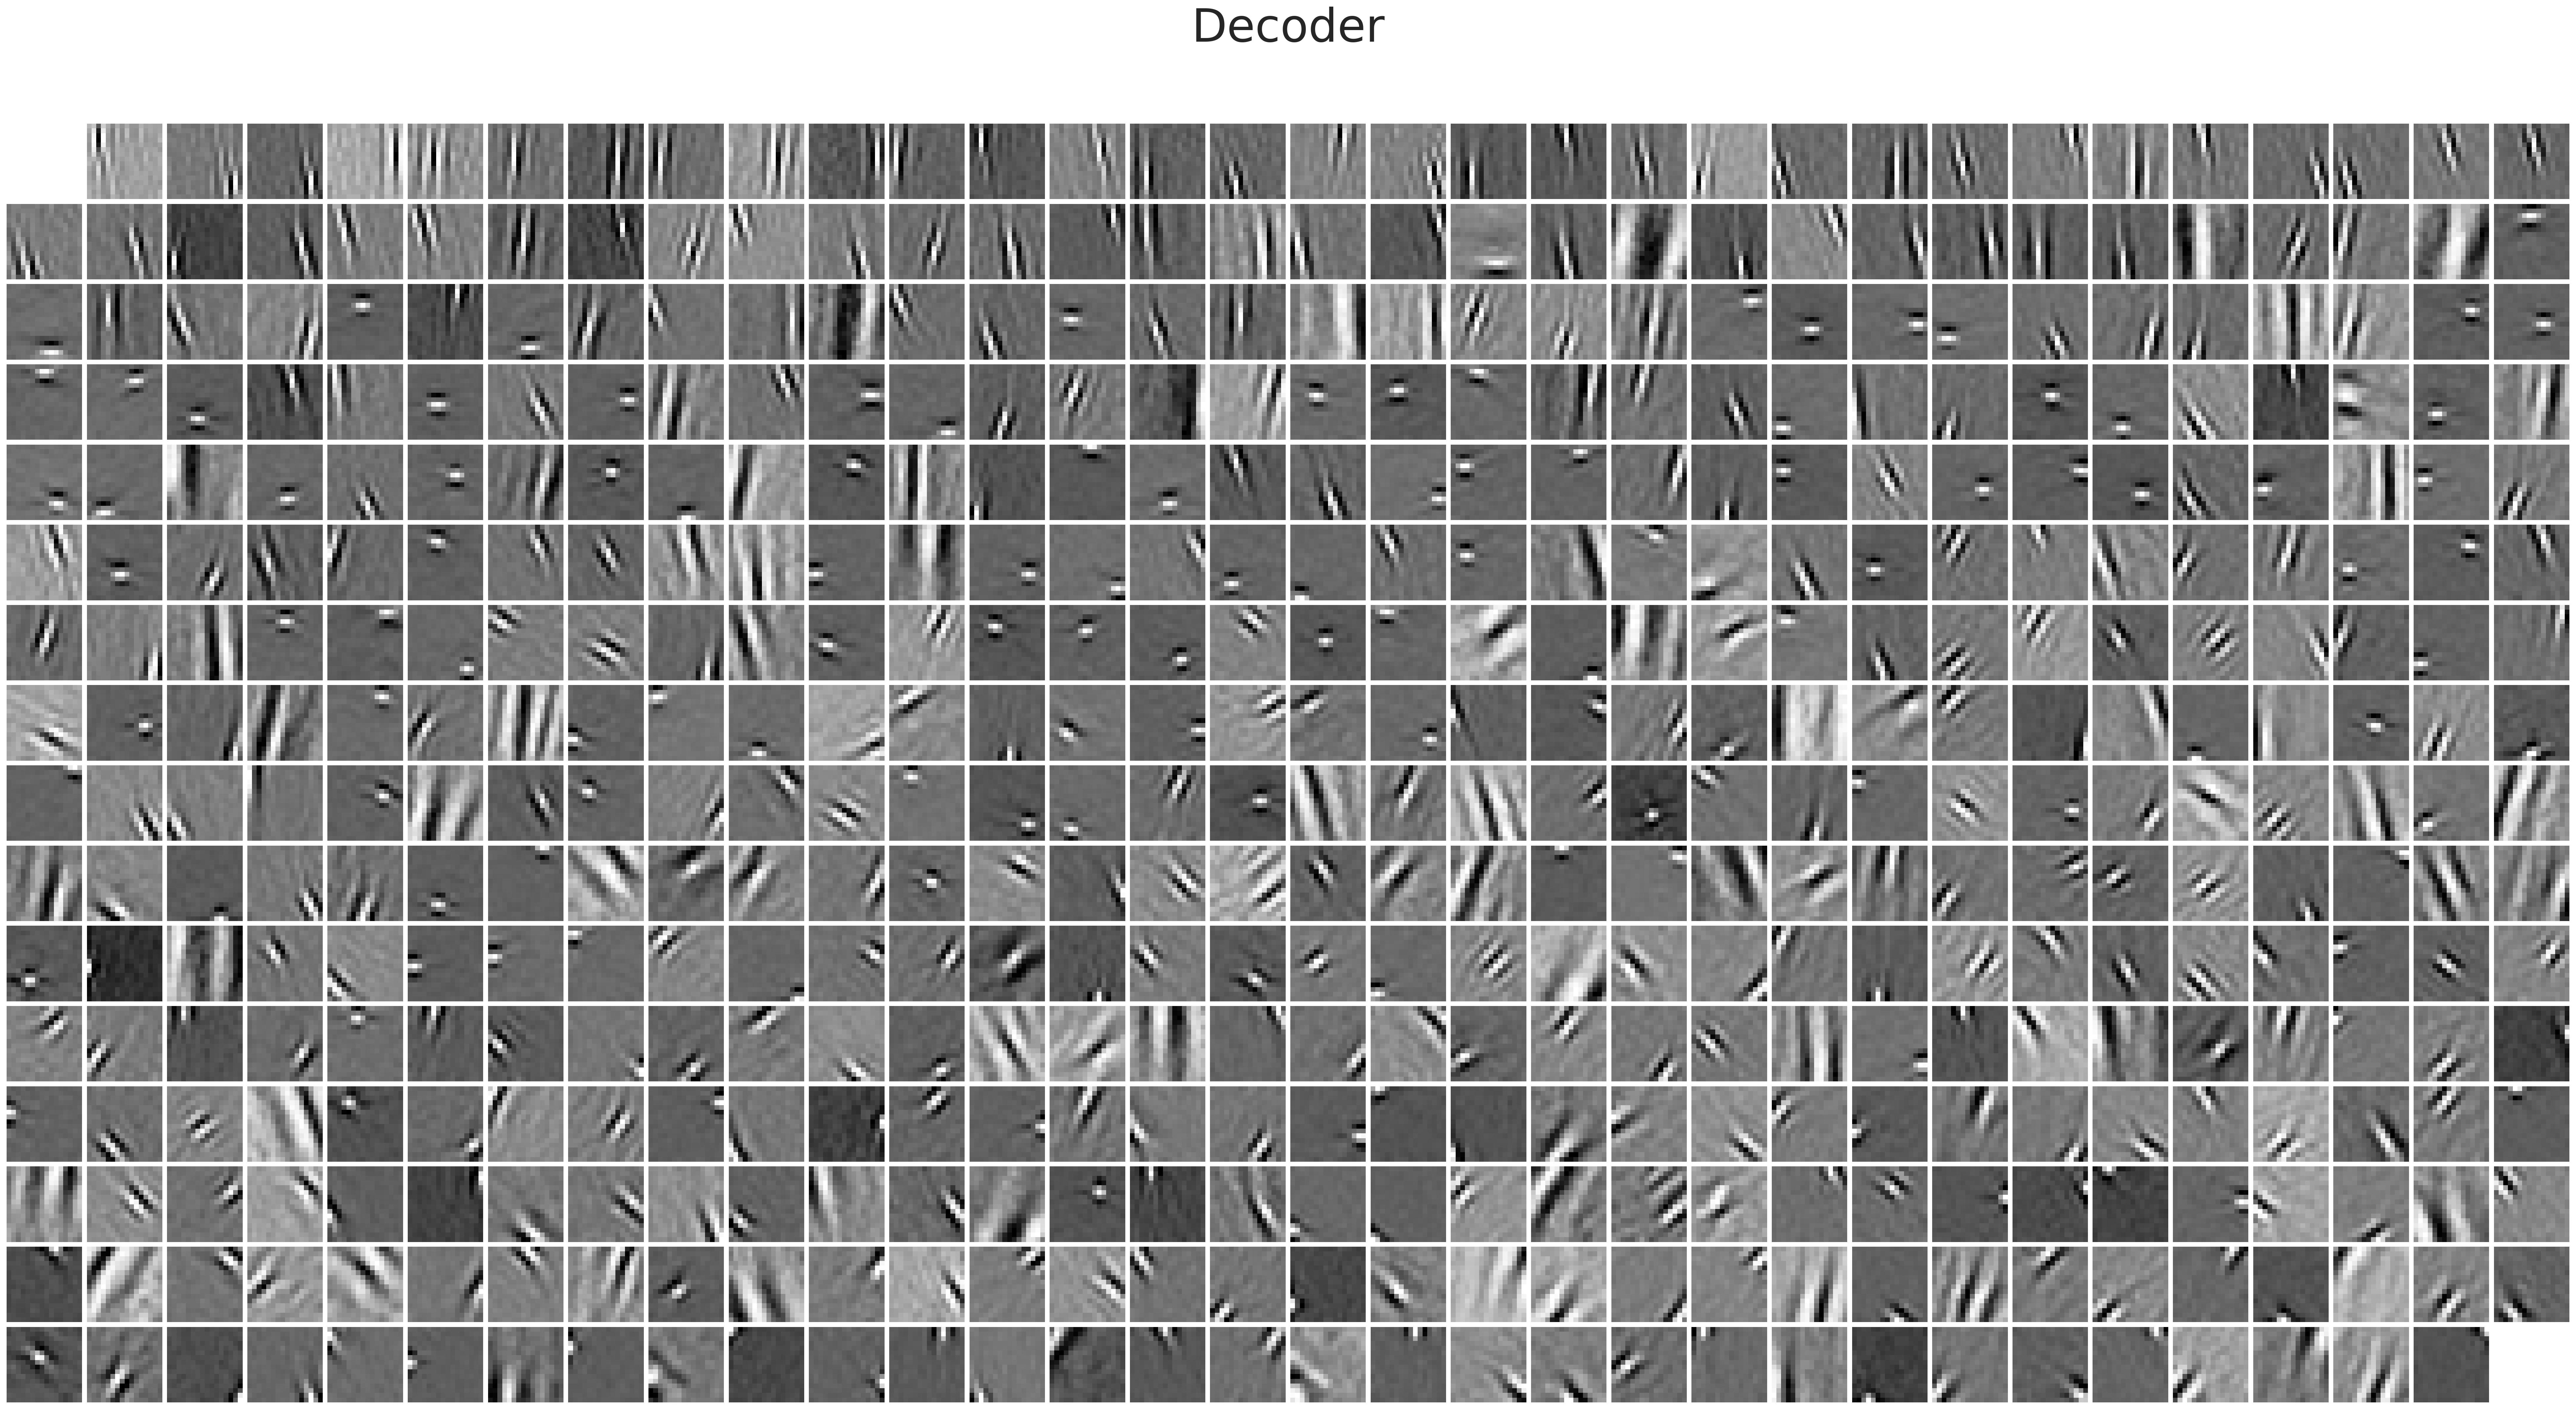

In [33]:
fig, ax = create_figure(1, 1, (50, 26), dpi=200)
ax.imshow(grid_dec, cmap='Greys_r')
ax.set_title('Decoder', fontsize=50, y=1.06)
remove_ticks(ax)
plt.show()

In [34]:
with torch.inference_mode():
    w_dec = tr.model.fc_dec.weight.detach().data
    w_enc = tr.model.fc_enc.weight.detach().data

    w_dec = w_dec[:, ~dead]
    w_enc = w_enc[~dead]

    cos_sim = F.cosine_similarity(w_dec.T, w_enc)
    slope = torch.einsum('ic, ci -> c', w_dec, w_enc)
    slope /= torch.norm(w_enc, dim=1).pow(2)

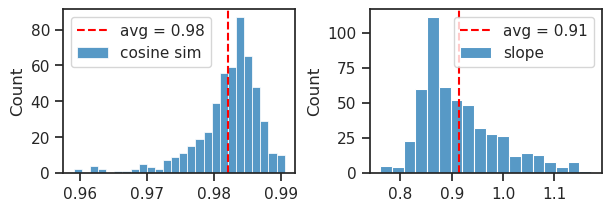

In [35]:
fig, axes = create_figure(1, 2, (6, 2), layout='constrained')

sns.histplot(to_np(cos_sim), label='cosine sim', ax=axes[0])
sns.histplot(to_np(slope), label='slope', ax=axes[1])

_avg = cos_sim.mean().item()
axes[0].axvline(_avg, color='r', ls='--', label=f'avg = {_avg:0.2f}')
_avg = slope.mean().item()
axes[1].axvline(_avg, color='r', ls='--', label=f'avg = {_avg:0.2f}')

for ax in axes.flat:
    ax.legend()
plt.show()

In [36]:
tot = np.prod(data['z'].shape)
portions = data['z'][:, ~dead].ravel().astype(int)
portions = collections.Counter(portions)
portions = {
    k: v / tot for k, v in
    portions.most_common()
}
portions = {
    k: np.round(v * 100, 1) for
    k, v in portions.items()
    if v > 0.001
}

In [37]:
portions

{0: 68.5, 1: 24.1, 2: 5.5, 3: 1.1, 4: 0.3}

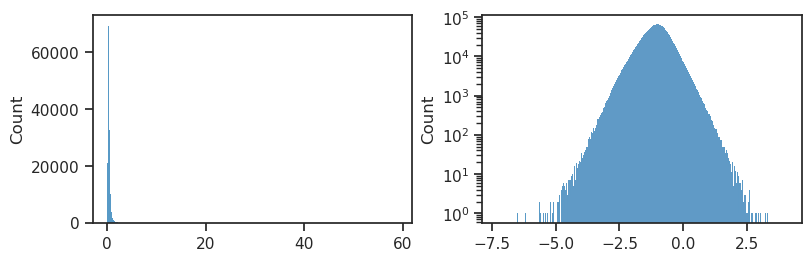

In [41]:
x2p = rates['r*dr'][:, ~dead].ravel()

fig, axes = create_figure(1, 2, (8, 2.5), layout='constrained')
sns.histplot(x2p, ax=axes[0])
sns.histplot(np.log(x2p), ax=axes[1])
axes[1].set_yscale('log')